In [1]:
import pandas as pd
import pandahouse as ph
import scipy.stats as stats
from scipy.stats import ttest_ind
import seaborn as sns
import numpy as np
import hashlib
import matplotlib.pyplot as plt

In [24]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230220',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-01-31' and '2023-02-06'
    and exp_group in (1,2,0,3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)


In [26]:
Тест между группами 0 и 3 по метрике линеаризованных лайков.

In [3]:
control_ctr_0 = df[df.exp_group == 0].likes.sum()/df[df.exp_group == 0].views.sum()

In [9]:
lin_ctr_0 =(df[df.exp_group == 0].likes - control_ctr_0 * df[df.exp_group == 0].views).to_numpy()
lin_ctr_3 =(df[df.exp_group == 3].likes - control_ctr_0 * df[df.exp_group == 3].views).to_numpy()

<AxesSubplot:xlabel='ctr', ylabel='Count'>

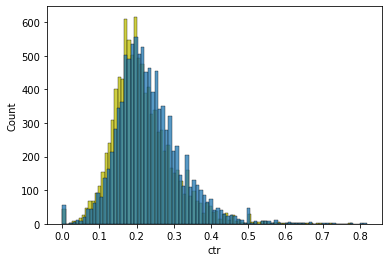

In [15]:
# Посмотрим на графике распределение CTR
sns.histplot(df[df.exp_group == 0].ctr,color='y') 
sns.histplot(df[df.exp_group == 3].ctr)

In [5]:
# T-test по CTR
stats.ttest_ind(df[df.exp_group == 0].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

<AxesSubplot:ylabel='Count'>

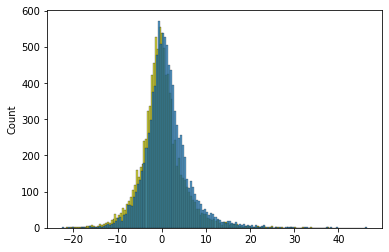

In [16]:
# Посмотрим на графике распределение CTR with linearized likes
sns.histplot(lin_ctr_0,color='y') 
sns.histplot(lin_ctr_3)

In [10]:
# T-test по CTR with linearized likes
stats.ttest_ind(lin_ctr_0,
                lin_ctr_3,
                equal_var=False)

Ttest_indResult(statistic=-15.214995460903827, pvalue=5.4914249479690016e-52)

In [ ]:
# Чувствительность явно увеличилась, p-value значительно уменьшился, и показывает статистически 
# значимые отличия. Отвергаем H0.

In [ ]:
Тест между группами 1 и 2 по метрике линеаризованных лайков

In [17]:
control_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()

In [18]:
lin_ctr_1 =(df[df.exp_group == 1].likes - control_ctr_1 * df[df.exp_group == 1].views).to_numpy()
lin_ctr_2 =(df[df.exp_group == 2].likes - control_ctr_1 * df[df.exp_group == 2].views).to_numpy()

<AxesSubplot:xlabel='ctr', ylabel='Count'>

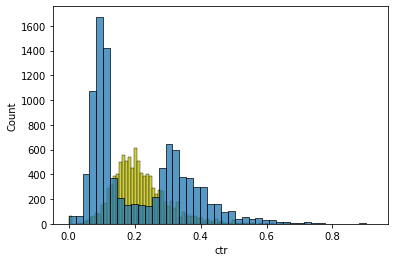

In [19]:
# Посмотрим на графике распределение CTR
sns.histplot(df[df.exp_group == 1].ctr,color='y') 
sns.histplot(df[df.exp_group == 2].ctr)

In [20]:
# T-test по CTR
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

<AxesSubplot:ylabel='Count'>

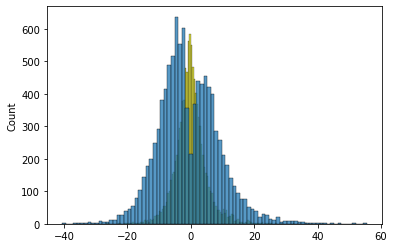

In [21]:
# Посмотрим на графике распределение CTR with linearized likes
sns.histplot(lin_ctr_1,color='y') 
sns.histplot(lin_ctr_2)

In [22]:
# T-test по CTR with linearized likes
stats.ttest_ind(lin_ctr_1,
                lin_ctr_2,
                equal_var=False)

Ttest_indResult(statistic=6.122579994775974, pvalue=9.439432187037644e-10)

In [ ]:
# Вау! Координальные изменения в p-value после линеаризации лайков!!! Мы увидели статистически
# значимые отличия. Отвергаем H0.

In [ ]:
По итогом т-тестов видно, что чувствительность CTR в разы увеличилась и на группах 0,3 и на 1,2.
И в случае групп 1,2 мы смогли увидеть уменьшение p-value до статзначимого, значит изменения 
есть в лайках на пользователя и в пользовательских CTR. 